In [1]:
import pandas as pd
import numpy as np
import pyodbc as db
import datetime

from scipy import stats as sps
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from IPython.display import clear_output

from sourcing import Covid

%config InlineBackend.figure_format = 'retina'

Borrowed from: https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb

In [2]:
Rt_MAX = 12
GAMMA = 1/7
SIGMAS = np.linspace(1 / 20, 1, 20)

In [3]:
def prepare_cases(cases, min_cases=100, window=7, std=2):
    """New cases smoothed based on rolling window / std & truncated based on minimum number of cases"""
    
    new_cases = cases.diff()
    
    #CAVEAT: includes future observations (not trying to project, just uncover past data)
    # Makes estimates for most recent 3 days less statistically powerful (less observations)
    smoothed = new_cases.rolling(window, win_type='gaussian', min_periods=1, center=True).mean(std=std).round()
    
    idx_start = np.searchsorted(smoothed, min_cases)
    
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

In [4]:
def highest_density_interval(pmf, p=.9):
    """HDI: Which points in distribution are most credible / have most coverage"""
    
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf], index=pmf.columns)
    
    cumulative_sum = np.cumsum(pmf.values)
    
    # N x N matrix of total probability mass for each low, high
    total_p = cumulative_sum - cumulative_sum[:, None]
    
    # Return all indices with total_p > p
    lows, highs = (total_p > p).nonzero()
    
    # Find the smallest range (highest density)
    if len(highs) == 0:
        low, high = (np.nan, np.nan)
    else:
        best = (highs - lows).argmin()
    
        low = pmf.index[lows[best]]
        high = pmf.index[highs[best]]
    
    return pd.Series([low, high], index=['Low', 'High'])

In [5]:
def _rt_range(max=Rt_MAX):
    return np.linspace(0, max, max * 100 + 1)

def get_posteriors(sr, sigma=0.15, gamma=GAMMA):
    
    rt_range = _rt_range()

    # (1) Calculate Lambda
    lam = sr[:-1].values * np.exp(gamma * (rt_range[:, None] - 1))

    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(data = sps.poisson.pmf(sr[1:].values, lam), index=rt_range, columns=sr.index[1:])
    
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=rt_range, scale=sigma).pdf(rt_range[:, None]) 

    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    
    # (4) Calculate the initial prior
    prior0 = sps.gamma(a=4).pdf(rt_range)  #prior0 = np.ones_like(rt_range)/len(rt_range)
    prior0 /= prior0.sum()

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(index=rt_range, columns=sr.index, data={sr.index[0]: prior0})
    
    # (5) Iteratively apply Bayes' rule
    log_likelihood = 0.0
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        log_likelihood += np.log(denominator)
    
    return posteriors, log_likelihood

In [6]:
def generate_posteriors(data, gamma=GAMMA, sigmas=SIGMAS):
    
    results = {}
    for name, cases in data.groupby(level=0):
        
        new, smoothed = prepare_cases(cases)
        
        if smoothed.empty:
            continue

        result = {}
        result['posteriors'] = []
        result['log_likelihoods'] = []

        for sigma in sigmas:
            posteriors, log_likelihood = get_posteriors(smoothed, gamma=gamma, sigma=sigma)
            result['posteriors'].append(posteriors)
            result['log_likelihoods'].append(log_likelihood)
        
        results[name] = result
    
    return results

def max_likelihood(posteriors, sigmas):
    """Find index with largest log likelihood total"""
    total_log_likelihoods = np.zeros_like(sigmas)

    for name, result in posteriors.items():
        total_log_likelihoods += result['log_likelihoods']

    return total_log_likelihoods.argmax()  

In [7]:
def generate_results(data, gamma=GAMMA, sigmas=SIGMAS):
    
    posteriors = generate_posteriors(data, gamma=gamma, sigmas=sigmas)
    max_likelihood_index = max_likelihood(posteriors, sigmas)
    
    results = {}
    for name, result in posteriors.items():
        
        region_posteriors = result['posteriors'][max_likelihood_index]
        hdis = highest_density_interval(region_posteriors)
        most_likely = region_posteriors.idxmax().rename('ML')
        
        results[name] = pd.concat([most_likely, hdis], axis=1)
    
    return results

In [8]:
# Colors
ABOVE = [1, 0, 0]
MIDDLE = [1, 1, 1]
BELOW = [0, 0, 0]
COLOR_MAP = ListedColormap(np.r_[np.linspace(BELOW,MIDDLE,25), np.linspace(MIDDLE,ABOVE,25)])
COLOR_MAPPED = lambda y: np.clip(y, .5, 1.5)-.5

def plot_rt(result, ax, name, start_date='2020-03-01'):
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index, values, s=40, lw=.5, c=COLOR_MAP(COLOR_MAPPED(values)), edgecolors='k', zorder=2)
    
    # aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index), result['Low'].values, bounds_error=False, fill_value='extrapolate')
    highfn = interp1d(date2num(index), result['High'].values, bounds_error=False, fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp(start_date), end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended, lowfn(date2num(extended)), highfn(date2num(extended)), color='k', alpha=.1, lw=0, zorder=3)
    
    # formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.set_title(f"{name}")
    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);  
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(pd.Timestamp(start_date), result.index.get_level_values('date')[-1] + pd.Timedelta(days=1))

In [9]:
REGIONS = ['Italy', 'Sweden', 'United Kingdom', 'Japan', 'US', 'New York City - New York']
cases_by_region = Covid(regions=REGIONS).get_cases().cases
cases_by_region.tail()

region          date      
United Kingdom  2020-05-05    196243
                2020-05-06    202359
                2020-05-07    207977
                2020-05-08    212629
                2020-05-09    216525
Name: cases, dtype: int64

In [10]:
results = generate_results(cases_by_region)

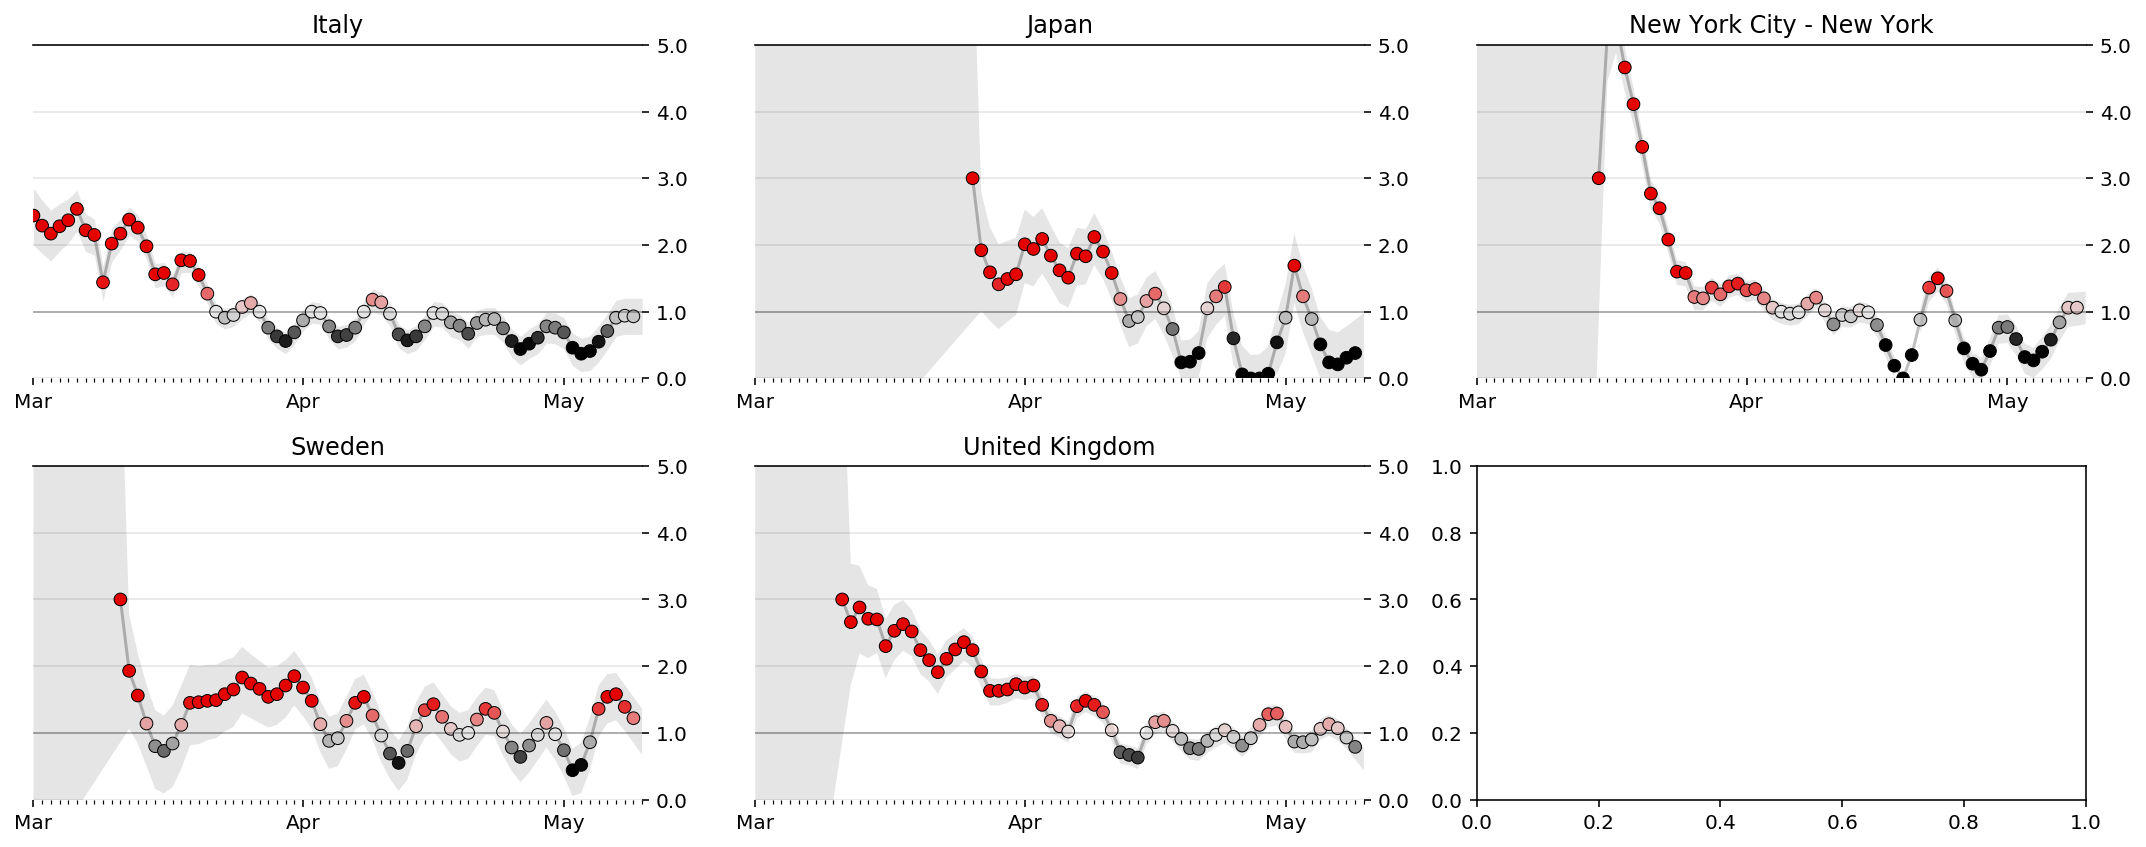

In [11]:
NCOLS = 3

def render_plots(results, regions=None):
    if regions is None: 
        regions = list(results.keys())
        
    nrows = int(np.ceil(len(regions) / NCOLS))
    fig, axes = plt.subplots(nrows=nrows, ncols=NCOLS, figsize=(15, nrows * 3))

    for i, region in enumerate(regions):
        result = results[region].reset_index(level=0, drop=True)
        plot_rt(result, axes.flat[i], region)

    fig.tight_layout()
    fig.set_facecolor('w')

_ = render_plots(results)

In [12]:
STANDARD_COLOR_MAP = plt.get_cmap('tab20')

def create_color_map(groups, color_map=STANDARD_COLOR_MAP):
    groups = list(set(groups))
    return {groups[x]: color_map(1. * x / len(groups)) for x in range(len(groups))}

In [13]:
def plot_current(results):
    fig, ax = plt.subplots(figsize=(15, 5))
    width = 1.3
    color_map = create_color_map(groups=list(results.keys()))
    
    for result_type, result in results.items():
        result = pd.concat(result.values()).sort_index().groupby(level=0)[['ML', 'High', 'Low']].last().sort_values('ML')
        
        width = width * 0.75
        err = result[['Low', 'High']].sub(result['ML'], axis=0).abs()
        bars = ax.bar(result.index, result['ML']
                      , width=width
                      , color=color_map[result_type]
                      , ecolor=color_map[result_type]
                      , alpha=width
                      , capsize=2
                      , error_kw={'alpha': 0.5, 'lw': 1}
                      , yerr=err.values.T
                      , label=result_type
                     )
        
        ax.set_xticklabels(result.index.to_series(), rotation=90, fontsize=11)
        
    ax.margins(0)
    ax.set_ylabel('Most recent Rt')
    ax.set_ylim(0, 2.)
    
    ax.axhline(1.0, linestyle=':', color='r', lw=1)
    
    leg=ax.legend(handles=[Patch(label=value, color=color_map[value]) for value in results.keys()]
                  , title='Assumed time between infection to transmission'
                  , loc='upper left'
                 )

In [14]:
infection_durations = [4, 5.2, 7]
infection_duration_results = {Tinf: generate_results(cases_by_region, gamma=1/Tinf) for Tinf in infection_durations}

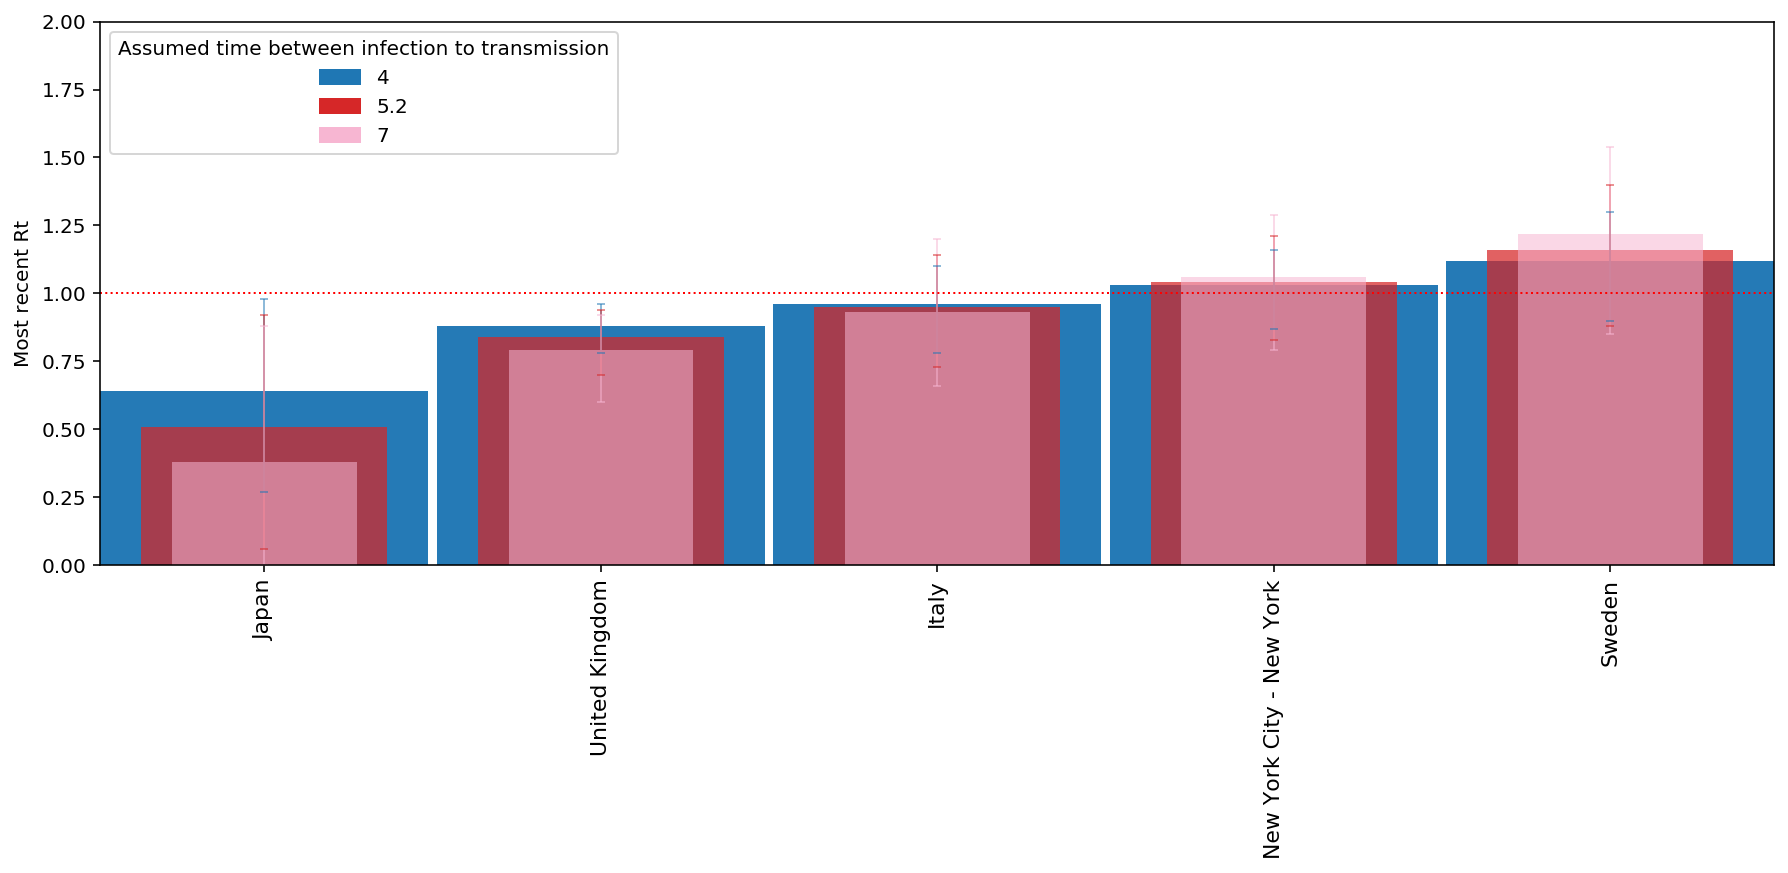

In [15]:
plot_current(infection_duration_results)